# Forecasting the closing price, Model: SARIMAX, Stock Token: CMG, Train/Test/Validation/: 80/10/10
- Dataset: 1313 rows x 7 columns (01/03/2019 - 31/05/2024) - exogenous variable: low price
----
### Model evaluation (Test set)
- RMSE: 1073.24
- MAE on test data: 891.14
- MAPE on test data: 2.39 %

### Import neccesary libraries


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

plt.style.use("default")

### Define the split type and stock name


In [35]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [36]:
# Choose the split_type and stock_name -> CMG - 8 1 1
split = 2  # 8 1 1
stock = 1  # CMG

## 1.Data preprocessing


In [37]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,13590,13590,13360,13480,9850,CMG
1,2019-03-04,13550,14060,13550,13970,118020,CMG
2,2019-03-05,13830,14490,13830,14460,222050,CMG
3,2019-03-06,14460,14720,13850,14060,224770,CMG
4,2019-03-07,14340,14340,13830,13830,112670,CMG
...,...,...,...,...,...,...,...
1308,2024-05-27,60500,61100,57000,59000,2265500,CMG
1309,2024-05-28,59800,62400,59200,62100,1479800,CMG
1310,2024-05-29,62100,63400,60000,60000,2384000,CMG
1311,2024-05-30,59000,60100,58100,59200,1814100,CMG


In [38]:
# Take the close price of FPT a
df = df[["low", "close"]]

df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [39]:
df.reset_index(drop=True)
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [40]:
# Shape of the dataframe
df.shape

(1313, 2)

In [41]:
df.dtypes

low      int64
close    int64
dtype: object

In [42]:
# Describe the dataframe
df.describe()

,low,close
count,1313.000000,1313.000000
mean,26235.587205,26832.390708
std,9802.115234,10097.555228
min,10780.000000,10880.000000
25%,17540.000000,17810.000000
50%,27510.000000,28380.000000
75%,33440.000000,34350.000000
max,63000.000000,63600.000000


## 2. Train model


In [43]:
# Defining the split size
train_size = int(split_type[split][0] * len(df))
test_size = int(split_type[split][1] * len(df))
val_size = len(df) - train_size - test_size

In [44]:
# splitting data into train, test and validation set
train_data = df[:train_size]
test_data = df[train_size : train_size + test_size]
val_data = df[train_size + test_size :]

In [45]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

X_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data["close"])

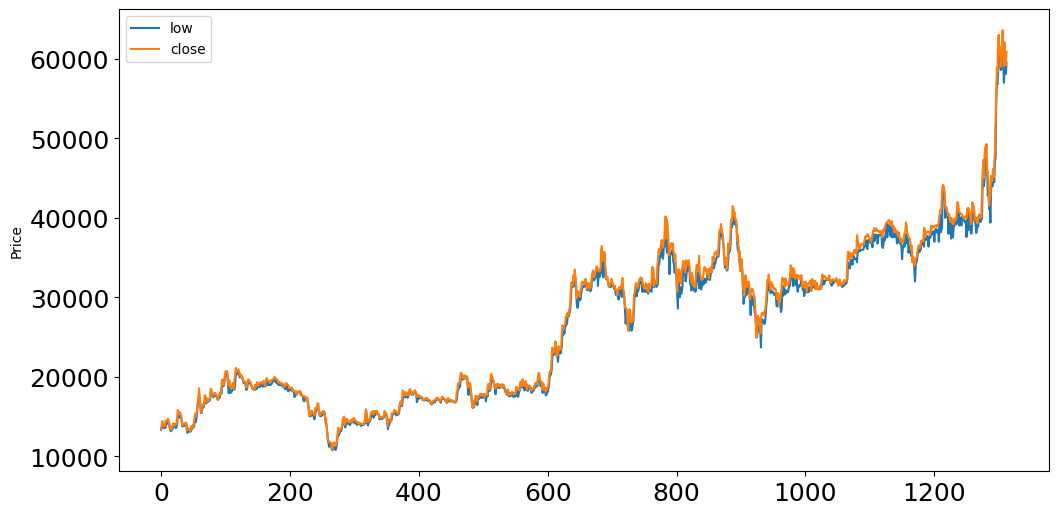

In [46]:
# Draw plot to look the dataset
df.plot(figsize=(12, 6), fontsize=18)
plt.ylabel("Price")
plt.show()

### Low price and close price are correlated => Good for SARIMAX model


In [47]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(0.9665029450963444,
 0.9938996357719839,
 21,
 1291,
 {'1%': -3.4354254066484664,
  '5%': -2.863781366113082,
  '10%': -2.56796331977745},
 20590.753479727184)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [48]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [49]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.429
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.483
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


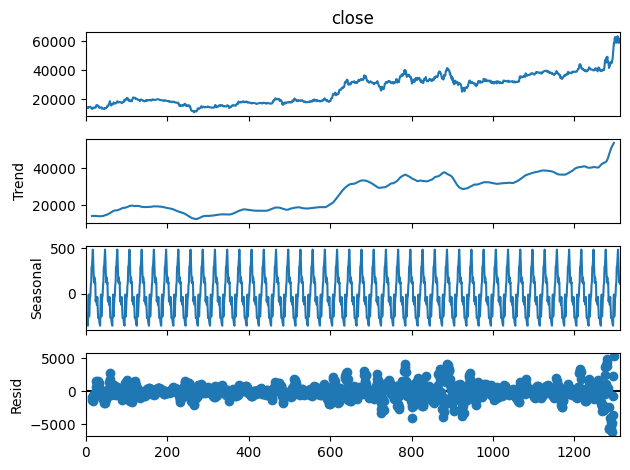

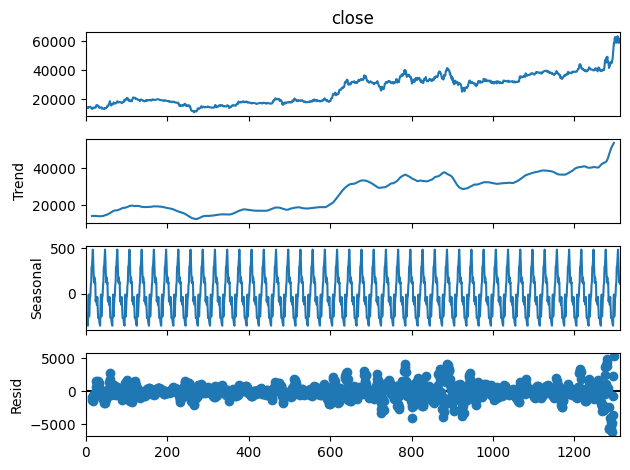

In [50]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [51]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [52]:
# Check again
adfuller(df_diff)

(-24.869647352545115,
 0.0,
 1,
 1047,
 {'1%': -3.4366111317433443,
  '5%': -2.864304451252086,
  '10%': -2.5682419034417707},
 16133.139050489852)

The p-value is 1.04^-15, less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

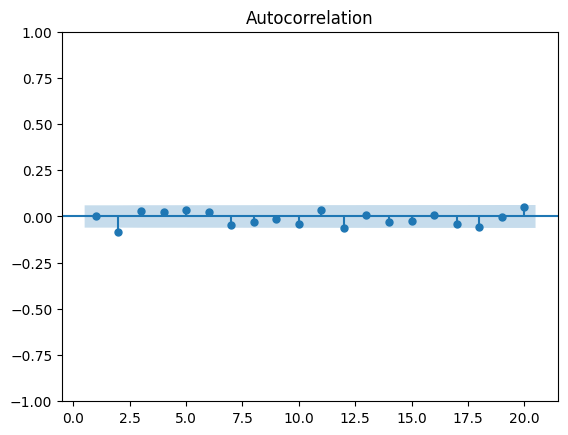

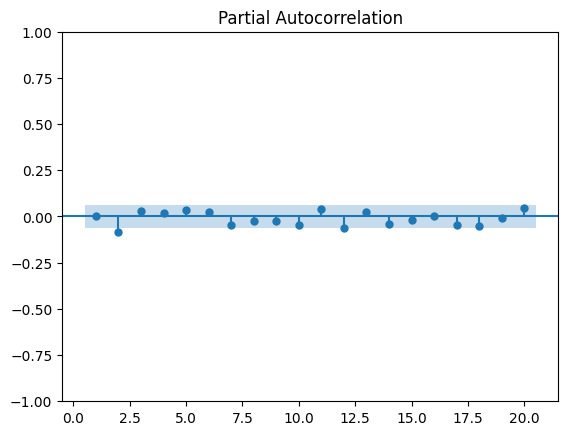

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [54]:
# Review the dataset again
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [55]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=16483.650, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=16486.468, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=16486.376, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=16482.487, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=16484.497, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=16484.403, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=16485.947, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=16485.604, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=16485.598, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=16481.867, Time=0.16 sec
 ARIMA(1,1,1)(1,0,0)[5] intercept   : AIC=16483.779, Time=0.16 sec
 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=16483.769, Time=0.18 sec
 ARIMA(1,1,1)(1,0,1)[5] intercept   : AIC=16485.701, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[5] i

In [56]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1050
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -8237.077
Date:                Mon, 03 Jun 2024   AIC                          16480.153
Time:                        21:21:51   BIC                          16495.020
Sample:                             0   HQIC                         16485.791
                               - 1050                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0123      0.021      0.597      0.551      -0.028       0.053
ma.L2         -0.0743      0.021     -3.472      0.001      -0.116      -0.032
sigma2      3.887e+05   1.07e+04     36.275      0.0

#### Use SARIMAX to train model


In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(0, 1, 2),
    seasonal_order=(0, 0, 0, 5),
)

model_fit = model1.fit()

### Test


In [58]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([32062.61804676, 31751.8569731 , 32150.22108331, 32039.04970372,
       31927.87832412, 31825.97122616, 31825.97122616, 31566.57134044,
       31714.79984657, 31714.79984657, 31751.8569731 , 31964.93545066,
       32150.22108331, 31927.87832412, 32150.22108331, 32437.41381393,
       34429.234365  , 34179.09876092, 34179.09876092, 33743.67752417,
       34651.57712419, 34762.74850379, 34466.29149153, 34179.09876092,
       34762.74850379, 35198.16974053, 34901.71272828, 34827.59847522,
       34827.59847522, 34901.71272828, 34466.29149153, 35633.59097728,
       35633.59097728, 35920.7837079 , 35920.7837079 , 35772.55520177,
       35920.7837079 , 35920.7837079 , 35920.7837079 , 35920.7837079 ,
       35920.7837079 , 36356.20494464, 36282.09069158, 36393.26207117,
       37004.70465894, 37004.70465894, 35994.89796096, 36865.74043445,
       37078.81891201, 36791.62618139, 36893.53327935, 36930.59040588,
       36643.39767526, 36791.62618139, 36207.97643852, 37366.01164263,
      

#### Validate


In [59]:
exg = np.array(val_data["low"])

y_pred_val = model_fit.predict(
    start=len(X_train), end=len(X_train) + len(y_val) - 1, exog=exg
)

y_pred_val

array([36666.96601831, 36680.45480179, 36717.51192833, 36282.09069158,
       38097.88989163, 37301.1616712 , 37041.76178548, 37403.06876916,
       37514.24014875, 37514.24014875, 36282.09069158, 37366.01164263,
       37301.1616712 , 37356.74736099, 38005.2470753 , 37680.99721815,
       37819.96144264, 38051.56848346, 38051.56848346, 36847.21187119,
       38097.88989163, 38329.49693245, 38329.49693245, 37912.60425897,
       38051.56848346, 38236.85411612, 36847.21187119, 39209.60368757,
       39997.06762637, 37958.92566713, 38236.85411612, 38514.7825651 ,
       42868.99493256, 42961.63774889, 42868.99493256, 42220.49521826,
       39626.49636105, 40413.96029985, 40413.96029985, 39904.42481004,
       39672.81776922, 37773.64003447, 39348.56791206, 39487.53213656,
       39163.28227941, 37217.7831365 , 39302.2465039 , 38653.7467896 ,
       37356.74736099, 38607.42538143, 38700.06819776, 39163.28227941,
       38885.35383042, 38885.35383042, 38977.99664675, 39950.7462182 ,
      

### Predict the next 30/60/90 days


In [60]:
# Predict next xx days
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [61]:
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [62]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Extrapolation variable
exog = np.array(val_data["low"])

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Predicted closing prices for the next 30 days:")
print(y_30_days_pred)

Predicted closing prices for the next 30 days:
[39374.00360024 39407.18902296 39426.88566219 39446.58230142
 39466.27894066 39485.97557989 39505.67221912 39525.36885836
 39545.06549759 39564.76213682 39584.45877605 39604.15541529
 39623.85205452 39643.54869375 39663.24533299 39682.94197222
 39702.63861145 39722.33525068 39742.03188992 39761.72852915
 39781.42516838 39801.12180762 39820.81844685 39840.51508608
 39860.21172531 39879.90836455 39899.60500378 39919.30164301
 39938.99828225 39958.69492148]


### Plotting the data


In [67]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(16, 9))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")
    plt.plot(val_data.index, val_data["close"], label="Validate")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")
    plt.plot(val_data.index, y_pred_val, label="Predicted Validate", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Next {days} days", linestyle="--"
    )
    plt.title(f"{stock_name[stock]} Stock Price Forecasting Using SARIMAX")
    plt.legend()
    plt.show()

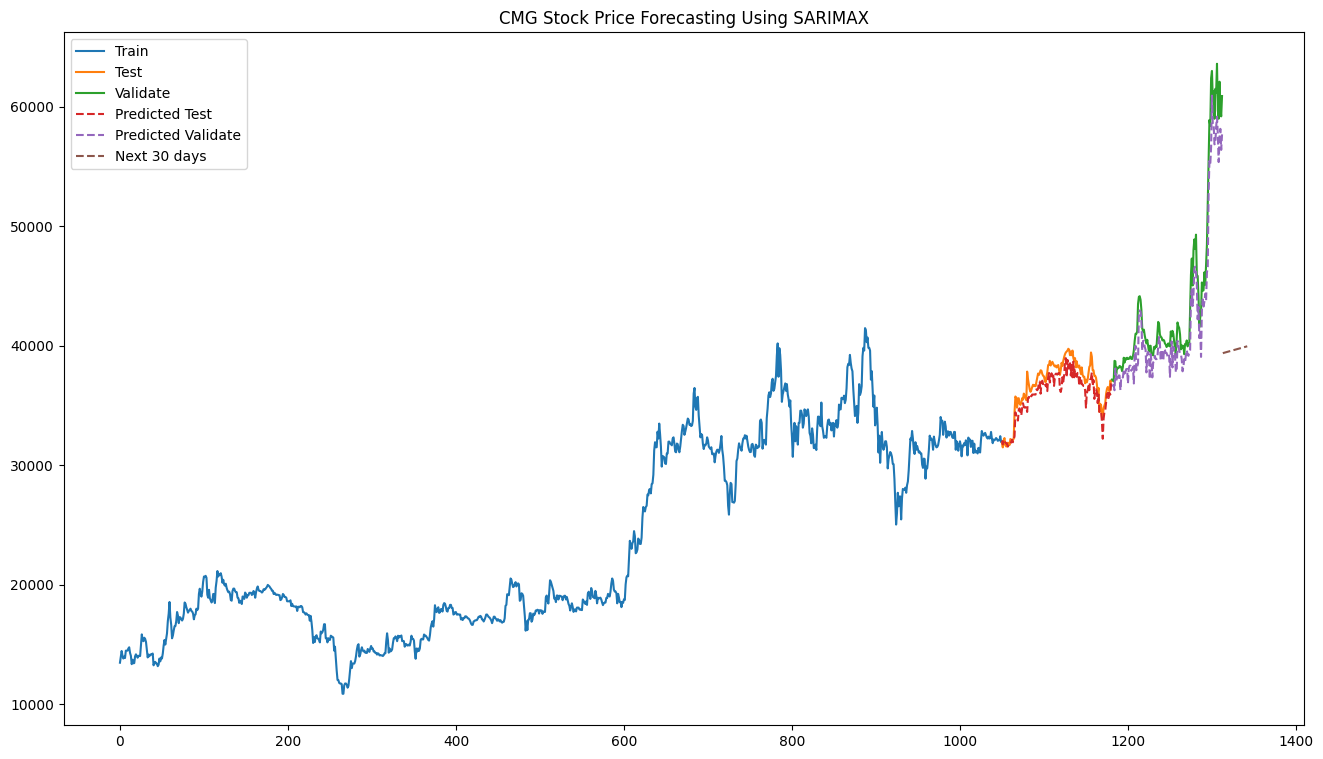

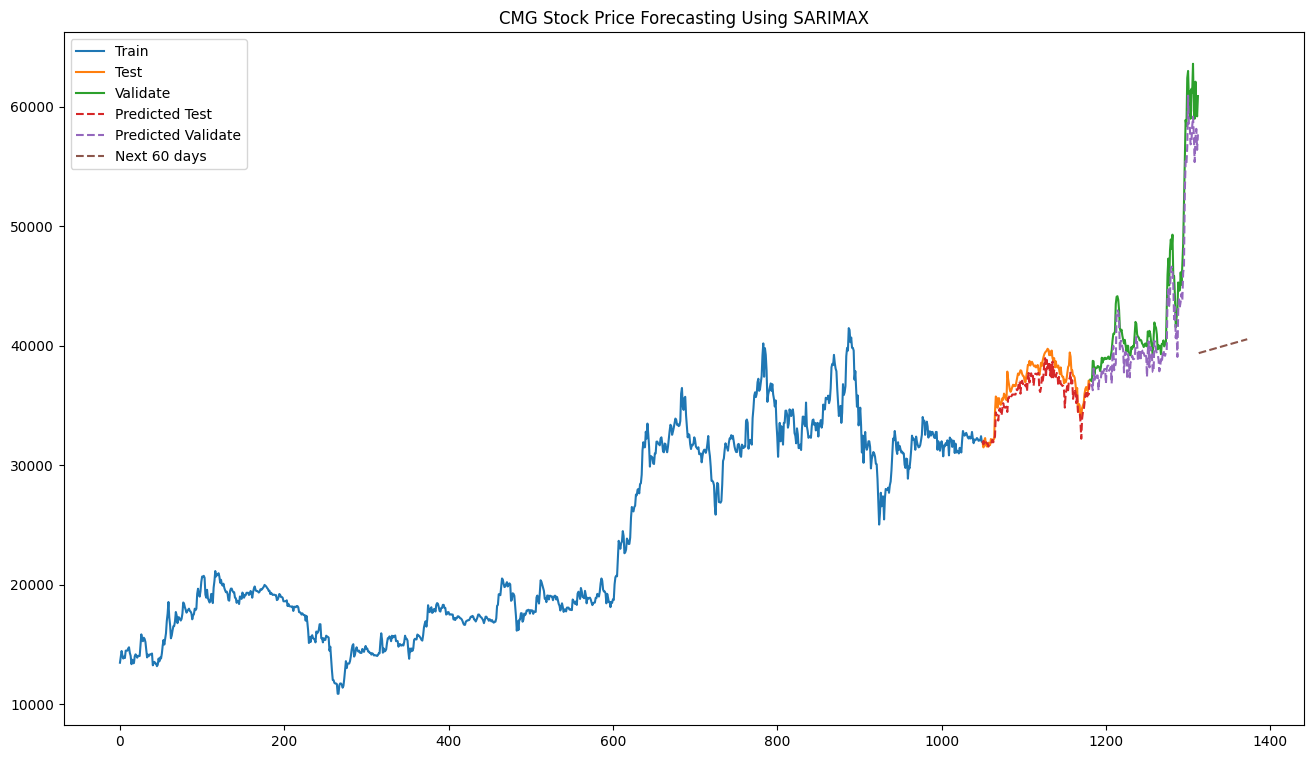

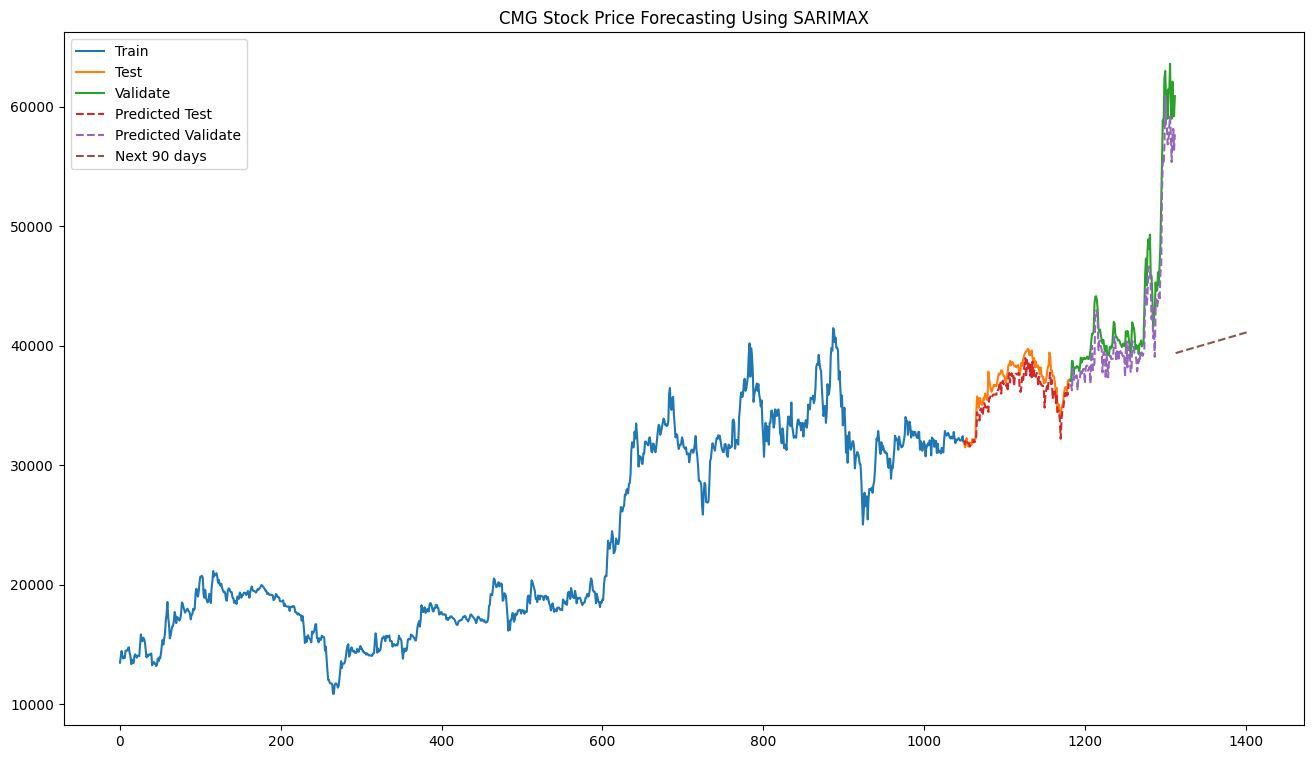

In [68]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [65]:
# Model evaluation on test set
print(f"RMSE on test data: {rmse(y_test, y_pred_test)}")
print(f"MAE on test data: {mae(y_test, y_pred_test)}")
print(f"MAPE on test data: {mape(y_test, y_pred_test) * 100} %")

RMSE on test data: 1073.236948898064
MAE on test data: 891.1415362399094
MAPE on test data: 2.3866189900367747 %


In [66]:
# Model evaluation on validation set
print(f"RMSE on validation data: {rmse(y_val, y_pred_val)}")
print(f"MAE on validation data: {mae(y_val, y_pred_val)}")
print(f"MAPE on validation data: {mape(y_val, y_pred_val) * 100} %")

RMSE on validation data: 1999.8331756459793
MAE on validation data: 1639.6813291793972
MAPE on validation data: 3.605169425931708 %
